In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import galsim
from IPython import display

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
dat = np.load('Cat-SFG-17-01-2020.npz')
dat.files

['nobj', 'listgal', 'flux1400sfg', 'sizesfg', 'randidx', 'e1', 'e2']

In [3]:
dat['listgal'].shape

(300, 96, 96)

In [4]:
img1 = np.abs(fits.open('psf2asec-96.psf.fits')[0].data[0,0,:,:])

### Loading PSF & SFG

In [5]:
gal = dat['listgal'][0,:,:]
psf = galsim.Image(img1, copy=True).array

psf /= np.sum(psf)

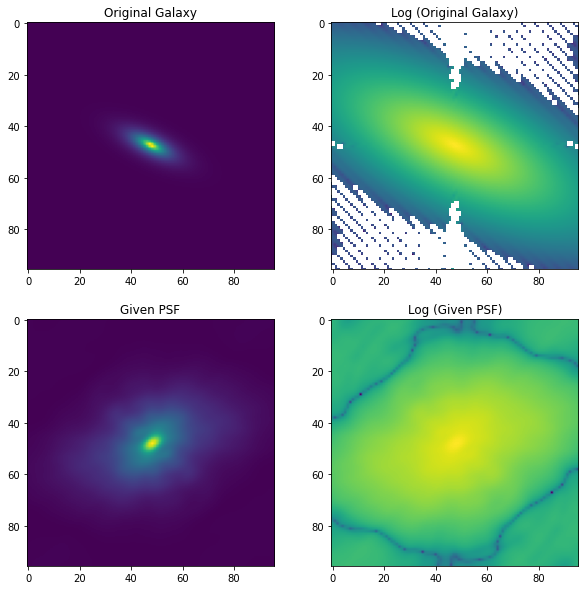

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.imshow(gal); ax1.set_title('Original Galaxy');
ax2.imshow(np.log10(gal)); ax2.set_title('Log (Original Galaxy)');
ax3.imshow(psf); ax3.set_title('Given PSF');
ax4.imshow(np.log10(psf)); ax4.set_title('Log (Given PSF)');

### FFT + Gaussian Noise

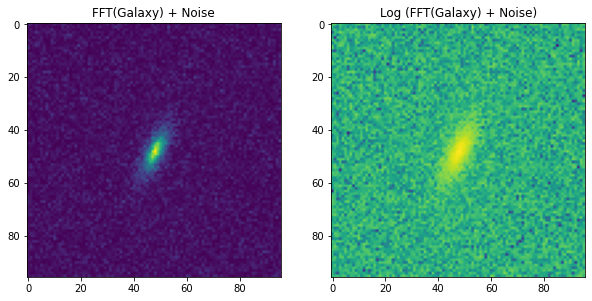

In [7]:
gal_fft = np.fft.fftshift(np.fft.fft2(gal))   
psf_fft = np.fft.fftshift(np.fft.fft2(psf))      

# SNR(x) = l2_norm(x)/sigma_noise 

SNR = 1.0e2                                                       # Signal to noise ratio in Fourier domain
sigma_noise = np.linalg.norm(gal_fft)/SNR                         # Standard deviation of noise

gal_fft_GSO = galsim.Image(gal_fft, copy=True)                    # Stored as GSO
gal_fft_GSO.addNoise(galsim.GaussianNoise(sigma = sigma_noise)) 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(np.abs(gal_fft_GSO.array)); ax1.set_title('FFT(Galaxy) + Noise');
ax2.imshow(np.log10(np.abs(gal_fft_GSO.array))); ax2.set_title('Log (FFT(Galaxy) + Noise)');

### Convolve with PSF

(0.06832032443786301, 0.06832032443786301)

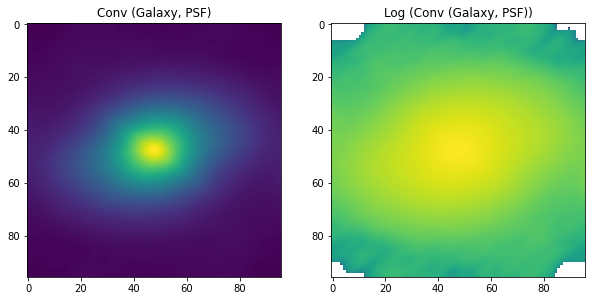

In [8]:
conv = np.multiply(gal_fft_GSO.array, psf_fft)

final_gal = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(conv))))  # IFFT to get back to brightness domain
final_gal = final_gal * (np.sum(gal)/np.sum(final_gal))                     # Normalisation

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(final_gal); ax1.set_title('Conv (Galaxy, PSF)');
ax2.imshow(np.log10(final_gal)); ax2.set_title('Log (Conv (Galaxy, PSF))');

np.sum(gal), np.sum(final_gal)

# Gradient Descent

In [9]:
# Utility Functions

def fftconvolve(image, kernel):

    x = np.fft.fftshift(np.fft.fftn(image))
    y = np.fft.fftshift(np.fft.fftn(kernel))

    return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x * y))))

def l1_norm(signal):

    return np.sum(np.abs(signal))


def sigma_mad(signal):

    return 1.4826 * np.median(np.abs(signal - np.median(signal)))


def fft(data):

    return (1 / np.sqrt(data.size) *
            np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(data))))


def ifft(data):

    return (np.sqrt(data.size) *
            np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(data))))


def soft_thresh(data, threshold):

    return np.around(np.maximum((1.0 - threshold /
                     np.maximum(np.finfo(np.float64).eps,
                                np.abs(data))), 0.0) * data,
                     decimals=15)


def nmse(signal_1, singal_2):

    return (np.linalg.norm(singal_2 - signal_1) ** 2 /
            np.linalg.norm(signal_1) ** 2)

In [10]:
def proj(xi):
    
    xi = np.maximum(xi,0)
    return xi


def grad_desc(alpha_rec, gamma, observation, psf, lambda_val):
    
    alpha_temp = alpha_rec - gamma * grad(observation, alpha_rec, psf)
    alpha_rec = soft_thresh(alpha_temp, lambda_val)
    return alpha_rec
   
    
def FISTA(tk, xk, alpha_rec, gamma, observation, psf, ST_lambda):
    
    x_k1 = xk
    alpha_temp = alpha_rec - gamma*grad(observation, alpha_rec, psf)
    alpha_temp = soft_thresh(alpha_temp, ST_lambda)
    xk = proj(alpha_temp)
    t_k1 = (1 + np.sqrt(1 + 4*tk**2))/2
    alpha_rec = xk + (tk - 1)/t_k1*(xk - x_k1)
    tk = t_k1
    return alpha_rec, tk, xk



# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)

# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, np.rot90(psf, 2))

# Function that performs simple forward backward splitting
def forwardBackward(observation, first_guess, psf, grad, lambda_val, n_iter=300, gamma=1.0, ST_lambda=1e-10):
    
    alpha_rec = first_guess
    cost = []
    nmse_arr = np.zeros(n_iter)
    x_opt = np.zeros(observation.shape)
    count = 0
    
    # FISTA Parameters
    tk = 1
    xk = alpha_rec
            
    for i in range(n_iter):
        
        #Simple gradient descent
        #alpha_rec = grad_desc(alpha_rec, gamma, observation, psf, lambda_val)
        
        # Gradient Descent with FISTA update
        alpha_rec, tk, xk = FISTA(tk, xk, alpha_rec, gamma, observation, psf, ST_lambda)
                
        
        cost.append(cost_func(observation, alpha_rec, psf, lambda_val))
        
        # Convert back to signal domain
        x_rec = np.abs(fft(alpha_rec))
        nmse_arr[i] = nmse(gal, x_rec)
        
        
        if (i!=0) and (nmse_arr[i]<nmse_arr[i-1]) and count==0:
            x_opt = x_rec
        elif (i!=0) and (nmse_arr[i]>nmse_arr[i-1]):
            count += 1
        
        
        if i%100==0 and i!=0:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,16))
            ax1.imshow(x_rec); ax1.set_title('Reconstruction after {} iterations'.format(i));
            ax2.imshow(np.log10(x_rec)); ax2.set_title('Log Intensity Scale');
         
            ax3.plot(x_rec[48,:], label='rec_im');
            ax3.plot(gal[48,:], label='gal'); 
            leg = ax3.legend()
            ax3.set_aspect(1.0/ax3.get_data_ratio()); ax3.set_title('Intensity Plot (Central Slice)')
            
            display.display(fig)
            display.clear_output(wait=True)
    
    return x_rec, x_opt, nmse_arr, cost

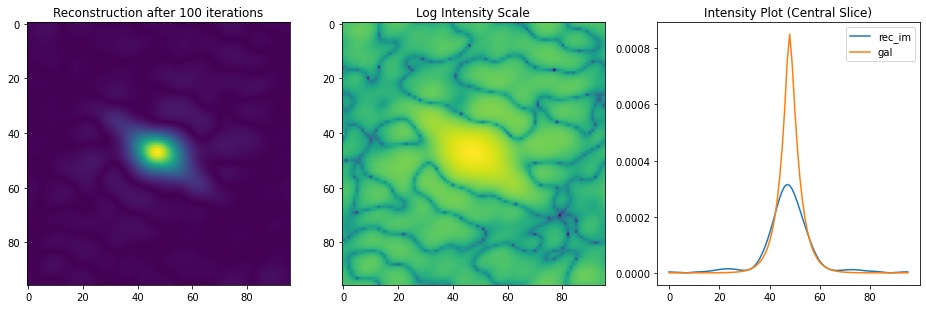

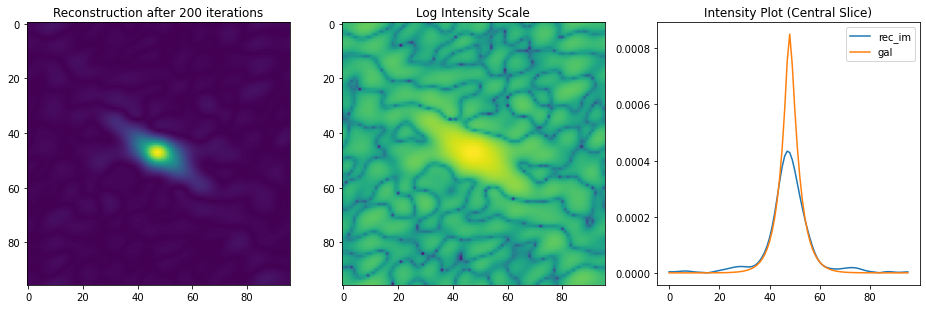

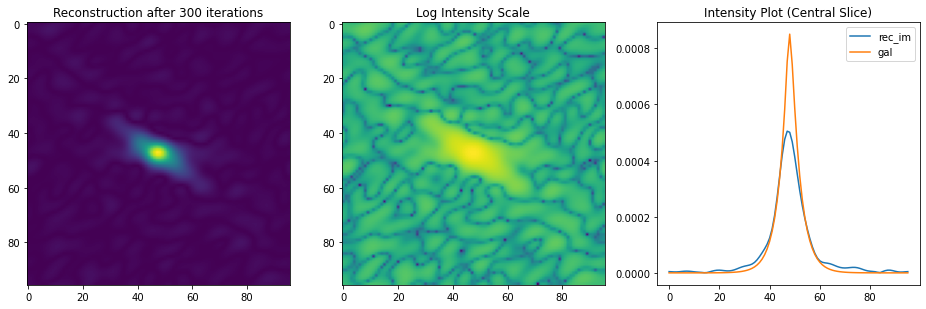

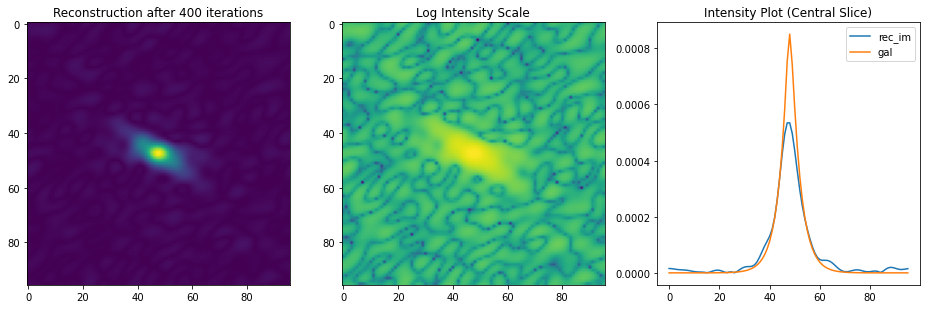

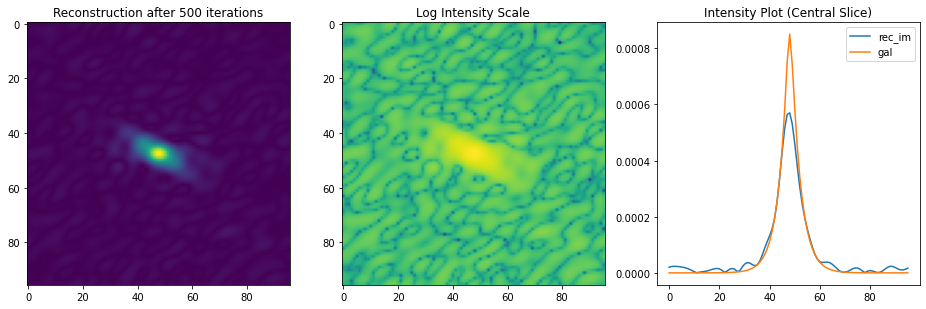

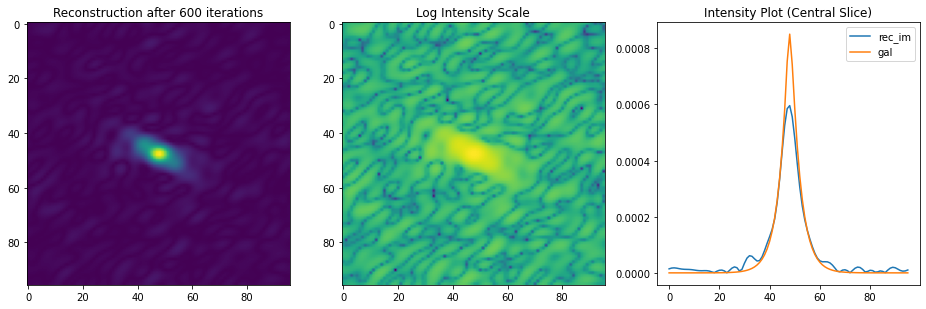

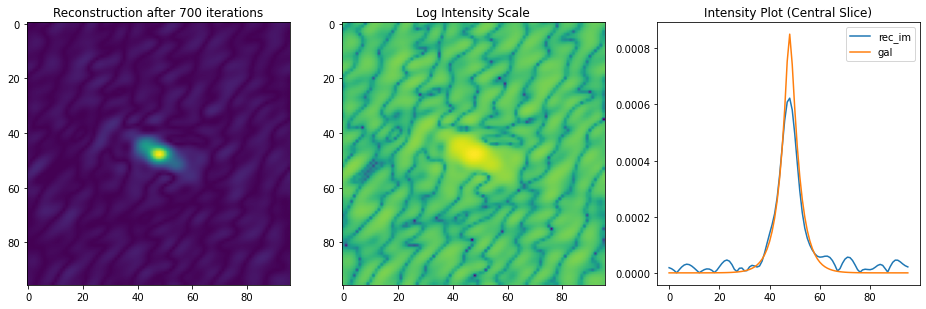

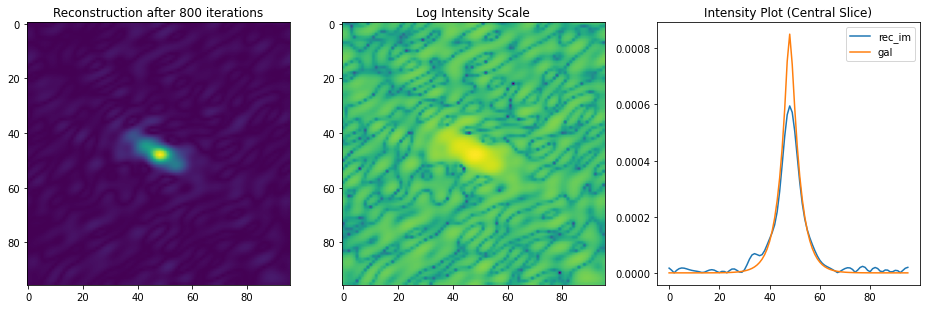

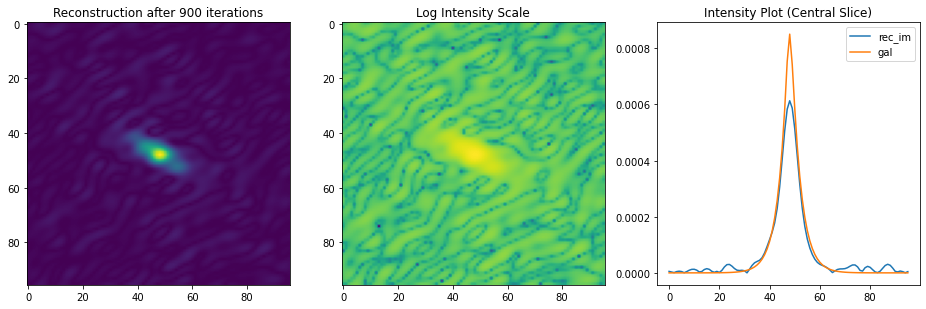

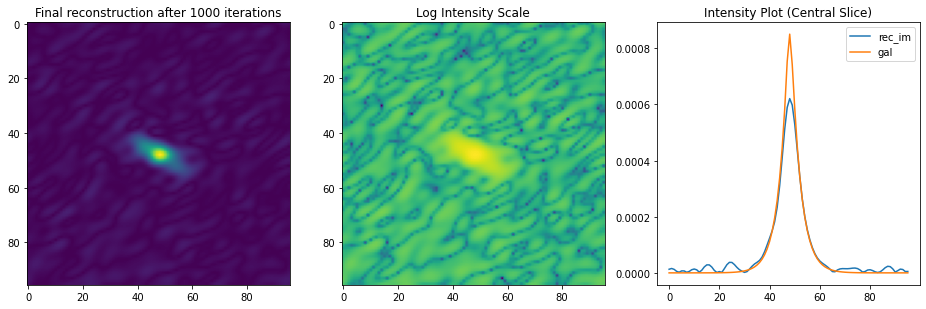

In [11]:
# The gradient
def grad(y, alpha_rec, psf):

    return ifft(Ht(H(fft(alpha_rec), psf) - y, psf))

# The cost function
def cost_func(y, alpha_rec, psf, lambda_):

    return (0.5 * np.linalg.norm(y - H(fft(alpha_rec), psf)) ** 2 + lambda_ * np.linalg.norm(alpha_rec))


# Number of Iterations
n_iter = 1000

# Deconvolve the image
x_rec, x_opt, nmse_arr, cost = forwardBackward(final_gal, np.zeros(final_gal.shape), psf, grad, 
                                               lambda_val=1e-4, n_iter=n_iter)


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,16))
ax1.imshow(x_rec); ax1.set_title('Final reconstruction after {} iterations'.format(n_iter));
ax2.imshow(np.log10(x_rec)); ax2.set_title('Log Intensity Scale');

ax3.plot(x_rec[48,:], label='rec_im');
ax3.plot(gal[48,:], label='gal'); 
leg = ax3.legend()
ax3.set_aspect(1.0/ax3.get_data_ratio()); ax3.set_title('Intensity Plot (Central Slice)')
plt.show(fig)

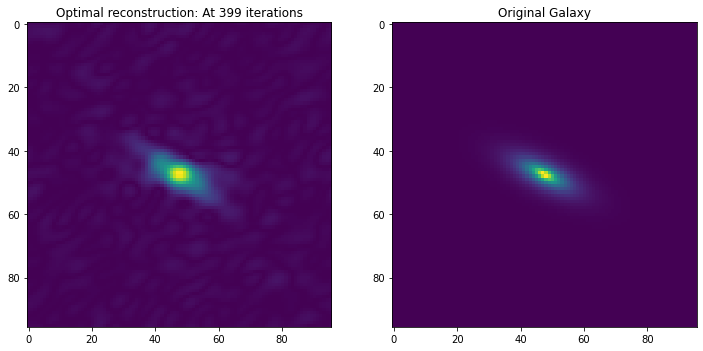

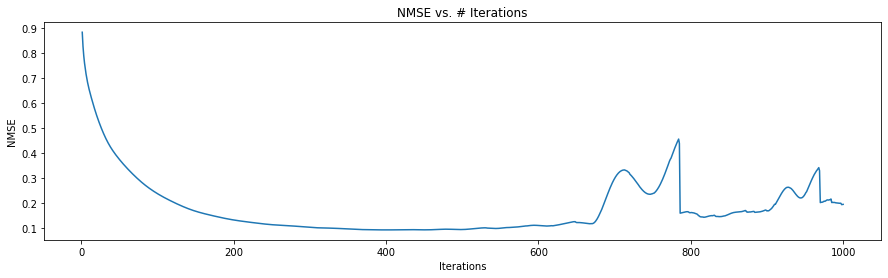


Minimum NMSE at 399 iterations


In [12]:
# Comparison

min_iter = np.where(nmse_arr == np.min(nmse_arr))[0][0]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12))
ax1.imshow(x_opt); ax1.set_title('Optimal reconstruction: At {} iterations'.format(min_iter));
ax2.imshow(gal); ax2.set_title('Original Galaxy');
plt.show(fig)

fig2, ax3 = plt.subplots(1,1, figsize=(15,4))
ax3.plot(np.arange(1,n_iter+1), nmse_arr); ax3.set_title('NMSE vs. # Iterations');
plt.xlabel('Iterations')
plt.ylabel('NMSE')
plt.show(fig2)
print('\nMinimum NMSE at {} iterations'.format(min_iter))